In [50]:
import sys
sys.path.append("../")

In [51]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pyspark import  SparkContext
from pyspark.sql import SparkSession
from ta import add_all_ta_features
from ta.utils import dropna
from utils.draw_candle_image import *
import json
import keras
import numpy as np
import numpy as np
import os
import pandas as pd
import random
import ta
import ta.momentum
import ta.trend
import ta.trend
import ta.volatility
import tensorflow as tf
from tabulate import tabulate

In [52]:
Date = "Date"
Macd = "Macd"
Macd_signal = "Macd_signal"
Macd_histogram = "Macd_histogram"
BB_avg = "BB_avg"
BB_high = "BB_high"
BB_low = "BB_low"
SMA = "SMA"
EMA_50 = "EMA_50"
EMA_9 = "EMA_9"
EMA_200 = "EMA_200"
Close = "Close"

In [53]:
symbol = input("Symbol = ").strip().lower()
interval = input("interval = ").lower()
file_csv = f'../data/{symbol}/{symbol}_to_now_{interval}.csv'
stock_df = pd.read_csv(file_csv)
stock_df[Date] = pd.to_datetime(stock_df[Date])
stock_df[Date] = stock_df[Date].dt.tz_localize(None)
stock_df.sort_values(by=Date, ascending=True, inplace=True)
stock_df.reset_index(drop=True, inplace=True)

stock_df[Macd] = ta.trend.macd(stock_df[Close], fillna=True)
stock_df[Macd_signal]= ta.trend.macd_signal(stock_df[Close], fillna=True)
stock_df[Macd_histogram] = ta.trend.macd_diff(stock_df[Close], fillna=True)

indicator_bb = ta.volatility.BollingerBands(close=stock_df[Close], window=20, window_dev=2, fillna=True)
stock_df[BB_avg] = indicator_bb.bollinger_mavg()
stock_df[BB_high] = indicator_bb.bollinger_hband()
stock_df[BB_low] = indicator_bb.bollinger_lband()

indicator_SMA = ta.trend.SMAIndicator(stock_df[Close], 20, fillna=True)
stock_df[SMA] = indicator_SMA.sma_indicator()

indicator_EMA_50 = ta.trend.EMAIndicator(stock_df[Close], 50, fillna=True)
stock_df[EMA_50] = indicator_EMA_50.ema_indicator()

indicator_EMA_9 = ta.trend.EMAIndicator(stock_df[Close], 9, fillna=True)
stock_df[EMA_9] = indicator_EMA_9.ema_indicator()

indicator_EMA_200 = ta.trend.EMAIndicator(stock_df[Close], 200, fillna=True)
stock_df[EMA_200] = indicator_EMA_200.ema_indicator()

In [54]:
stock_df.tail(1)

,Open,High,Low,Close,Volume,Date,Macd,Macd_signal,Macd_histogram,BB_avg,BB_high,BB_low,SMA,EMA_50,EMA_9,EMA_200
3728,96407.99,97836.0,95693.88,97185.17,9115.363698,2024-12-01,5011.965664,5623.285954,-611.32029,93721.8715,100888.3666,86555.3764,93721.8715,82819.783879,95726.795167,68467.005461


In [55]:
years = stock_df[Date].dt.year.unique()

In [56]:
years

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [57]:
def get_value_of_input(message, function_validate, function_convert, default=None):
    input_str = input(message).strip().lower()
    if not function_validate(input_str):
        return default
    else:
        return function_convert(input_str)

In [58]:
min_year = get_value_of_input(f"Min year = (default = {min(years)})", str.isdigit, int, min(years))
max_year = get_value_of_input(f"Max year = (default = {max(years)})", str.isdigit, int, max(years))

take_years = list(range(min_year, max_year + 1))
years_to_test = dict()
while True:
    year_to_test = input("year to test (also the year for continue learning) = (s for stop)")
    if not str.isdigit(year_to_test):
        break
    else:
        year_to_test = int(year_to_test)
    
    try:
        current_month = datetime.now().month
        from_month = get_value_of_input(f"year = {year_to_test}, from month = (default = 1)", str.isdigit, int, 1)
        to_month = get_value_of_input(f"year to test = {year_to_test}, to month = (default = {current_month})", str.isdigit, int, current_month)
        years_to_test[year_to_test] = list(range(from_month, to_month + 1))
    except Exception as err:
        continue
    
years = take_years
list_years_to_test_str = f"{min(years_to_test)}_{max(years_to_test)}"

In [59]:
figscale = 0.5
previous_days = 0
next_days = 2
days_result = 3
type_dataset = "ema_macd_trend"
folder_save = f"../dataset/{symbol}_with_{type_dataset}"
if os.path.exists(folder_save):
    print(f"Folder {folder_save} already exists.")
    continue_with_name = input("append name: ")
    folder_save += continue_with_name
    
os.makedirs(f"{folder_save}/model_save", exist_ok=True)
os.makedirs(f"{folder_save}/output_prediction_image", exist_ok=True)

indicator = {
    "show_macd": False,
    "show_macd_signal": False,
    "show_macd_histogram": False,

    "show_BB_avg": False,
    "show_BB_high": False,
    "show_BB_low": False,

    "show_SMA": False,
    "show_EMA_50": False,
    "show_EMA_200": False,
}

Folder ../dataset/btc_with_ema_macd_trend already exists.


In [60]:
print(f"{min_year=}")
print(f"{max_year=}")
print(f"{years_to_test=}")
print(f"{figscale=}")
print(f"{previous_days=}")
print(f"{next_days=}")
print(f"{days_result=}")
print(f"{type_dataset=}")
print(f"{folder_save=}")

min_year=2014
max_year=2024
years_to_test={2024: [0]}
figscale=0.5
previous_days=0
next_days=2
days_result=3
type_dataset='ema_macd_trend'
folder_save='../dataset/btc_with_ema_macd_trend'


In [61]:
# stock_df[stock_df["Date"].dt.year == 2014]

In [62]:
# draw_candle_image(
#     add_days_around_date("2019-09-21", stock_df, previous_days, next_days), 
#     show_x_y=False, 
#     show_volume=False, 
    
#     **indicator,
    
#     figscale=1, 
#     figcolor="black", 
#     preview_image=True,
#     return_image_tensor=False
# )

In [63]:
stock_df

,Open,High,Low,Close,Volume,Date,Macd,Macd_signal,Macd_histogram,BB_avg,BB_high,BB_low,SMA,EMA_50,EMA_9,EMA_200
0,465.864014,468.174011,452.421997,457.334015,2.105680e+07,2014-09-17,0.000000,0.000000,0.000000,457.334015,457.334015,457.334015,457.334015,457.334015,457.334015,457.334015
1,456.859985,456.859985,413.104004,424.440002,3.448320e+07,2014-09-18,-2.624024,-0.524805,-2.099219,440.887009,473.781021,407.992996,440.887009,456.044054,450.755212,457.006711
2,424.102997,427.834991,384.532013,394.795990,3.791970e+07,2014-09-19,-7.014744,-1.822793,-5.191951,425.523336,476.608398,374.438273,425.523336,453.642169,439.563368,456.387699
3,394.673004,423.295990,389.882996,408.903992,3.686360e+07,2014-09-20,-9.249402,-3.308115,-5.941288,421.368500,467.891770,374.845230,421.368500,451.887730,433.431493,455.915224
4,408.084991,412.425995,393.181000,398.821014,2.658010e+07,2014-09-21,-11.699137,-4.986319,-6.712818,416.859003,462.212070,371.505935,416.859003,449.806683,426.509397,455.347123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3724,91965.160000,97208.210000,91792.140000,95863.120000,9.496180e+03,2024-11-27,5734.717964,6191.237046,-456.519082,90497.662000,103166.849079,77828.474921,90497.662000,80412.467783,94227.683006,67315.653090
3725,95863.120000,96564.000000,94640.000000,95643.970000,9.872555e+03,2024-11-28,5504.350609,6053.859759,-549.509150,91454.372000,102545.440382,80363.303618,91454.372000,81009.781595,94510.940405,67597.526890
3726,95643.970000,98619.990000,95364.990000,97460.010000,8.612006e+03,2024-11-29,5406.005010,5924.288809,-518.283799,92493.214000,101563.543812,83422.884188,92493.214000,81654.888591,95100.754324,67894.666025
3727,97460.010000,97463.950000,96092.010000,96407.990000,4.571600e+03,2024-11-30,5183.424897,5776.116027,-592.691130,93295.012500,100601.159568,85988.865432,93295.012500,82233.441588,95362.201459,68178.380691


In [64]:
os.environ["JAVA_HOME"] = r'C:\Program Files\Java\jre-1.8'
os.environ["PYSPARK_PYTHON"] = "python" 
spark: SparkSession = SparkSession.builder.master("local").getOrCreate()

In [65]:
data_df_spark = spark.createDataFrame(stock_df)
data_stock = "data_stock"
data_df_spark.createOrReplaceTempView(data_stock)

In [66]:
data_stock_sub_1 = "data_stock_sub_1"
data_stock_include_previous_date = "data_stock_include_previous_date"
bullish_engulfing = "bullish_engulfing"
data_stock_sub_2 = "data_stock_sub_2"
data_stock_sub_3 = "data_stock_sub_3"
bearish_engulfing = "bearish_engulfing"
data_stock_sub_4 = "data_stock_sub_4"
data_stock_include_past_and_future_date = "data_stock_include_past_and_future_date"
data_stock_include_engulfing = "data_stock_include_engulfing"
recent_engulfing_type = "days_start_engulfing"
data_stock_day_bearish_engulfing = "data_stock_day_bearish_engulfing"
data_stock_include_group_engulfing = "data_stock_include_group_engulfing"
data_stock_include_group_engulfing_sub_1 = "data_stock_include_group_engulfing_sub_1"
start_and_end_date_of_group_engulfing = "start_and_end_date_of_group_engulfing"
data_stock_include_harami = "data_stock_include_harami"
data_stock_include_tweezer = "data_stock_include_tweezer"
data_stock_include_morning_and_evening_star = "data_stock_include_morning_and_evening_star"
data_stock_include_next_3_day = "data_stock_include_next_3_day"
recent_next_3_day_type = "recent_next_3_day_type"
data_stock_include_group_next_3_day = "data_stock_include_group_next_3_day"
data_stock_include_group_next_3_day_sub_1 = "data_stock_include_group_next_3_day_sub_1"
data_stock_include_group_sideway = "data_stock_include_group_sideway"
last_candle_index_in_group_next_3_day = "last_candle_index_in_group_next_3_day"
last_candle_index_in_group_next_3_day_sub_1 = "last_candle_index_in_group_next_3_day_sub_1"
data_stock_base = "data_stock_base"

Date = "Date"
Close = "Close"
Open = "Open"
High = "High"
Low = "Low"
Macd = "Macd"
Macd_signal = "Macd_signal"
Macd_histogram = "Macd_histogram"

Date_normalized = "Date_normalized"
Body_height = "Body_height"
Max_body_height_in_one_month_around = "Max_body_height_in_one_month_around"
Max_of_candle_body = "Max_of_candle_body"
Min_of_candle_body = "Min_of_candle_body"
Is_star_doji_candle = "Is_star_doji_candle"
Is_candle_up = "Is_candle_up"
Is_narrow_body_candle = "Is_narrow_body_candle"
Is_dragonfly_doji_candle = "Is_dragonfly_doji_candle"
Is_gravestone_doji_candle = "Is_gravestone_doji_candle"

Previous_date = "Previous_date"
Close_of_previous_day = "Close_of_previous_day"
Open_of_previous_day = "Open_of_previous_day"
High_of_previous_day = "High_of_previous_day"
Low_of_previous_day = "Low_of_previous_day"
Is_previous_day_candle_up = "Is_previous_day_candle_up"
Body_height_of_previous_day = "Body_height_of_previous_day"
Is_previous_day_start_doji_candle = "Is_previous_day_start_doji_candle"
Max_of_candle_body_of_previous_day = "Max_of_candle_body_of_previous_day"
Min_of_candle_body_of_previous_day = "Min_of_candle_body_of_previous_day"

Next_date = "Next_date"
Close_of_next_day = "Close_of_next_day"
Open_of_next_day = "Open_of_next_day"
High_of_next_day = "High_of_next_day"
Low_of_next_day = "Low_of_next_day"
Is_next_day_candle_up = "Is_next_day_candle_up"
Is_next_day_start_doji_candle = "Is_next_day_start_doji_candle"
Body_height_of_next_day = "Body_height_of_next_day"
Max_of_candle_body_of_next_day = "Max_of_candle_body_of_next_day"
Min_of_candle_body_of_next_day = "Min_of_candle_body_of_next_day"

Is_start_bullish_engulfing_candle = "Is_start_bullish_engulfing_candle"
Is_start_bearish_engulfing_candle = "Is_start_bearish_engulfing_candle"
Is_recent_candle_is_bullish_engulfing = "Is_recent_candle_is_bullish_engulfing"
Is_recent_candle_is_bearish_engulfing = "Is_recent_candle_is_bearish_engulfing"

Group_id_engulfing = "Group_id_engulfing"
Start_date_of_group = "Start_date_of_group"
End_date_of_group = "End_date_of_group"
Number_days_in_group = "Number_days_in_group"
Group_engulfing_type = "Group_engulfing_type"
Start_engulfing_candle_type = "Start_engulfing_candle_type"

GROUP_BULL = "GROUP_BULL"
GROUP_BEAR = "GROUP_BEAR"
GROUP_SIZEWAY = "GROUP_SIZEWAY"

Is_start_harami_up_candle = "Is_start_harami_up_candle"
Is_start_harami_down_candle = "Is_start_harami_down_candle"

Is_start_tweezer_top_candle = "Is_start_tweezer_top_candle"
Is_start_tweezer_bottom_candle = "Is_start_tweezer_bottom_candle"

Is_marubozu_candle = "Is_marubozu_candle"

Next_2_date = "Next_2_date"
Close_of_next_2_day = "Close_of_next_2_day"
Open_of_next_2_day = "Open_of_next_2_day"
High_of_next_2_day = "High_of_next_2_day"
Low_of_next_2_day = "Low_of_next_2_day"
Is_next_2_day_candle_up = "Is_next_2_day_candle_up"
Is_next_2_day_start_doji_candle = "Is_next_2_day_start_doji_candle"
Body_height_of_next_2_day = "Body_height_of_next_2_day"
Max_of_candle_body_of_next_2_day = "Max_of_candle_body_of_next_2_day"
Min_of_candle_body_of_next_2_day = "Min_of_candle_body_of_next_2_day"


Is_start_morning_star_candle = "Is_start_morning_star_candle"
Is_start_evening_star_candle = "Is_start_evening_star_candle"

Is_hammer_candle = "Is_hammer_candle"
Is_inverted_hammer_candle = "Is_inverted_hammer_candle"

Is_spin_candle = "Is_spin_candle"

Is_start_next_3_day_up_candle = "Is_start_next_3_day_up_candle"
Is_start_next_3_day_down_candle = "Is_start_next_3_day_down_candle"

Total_records = "Total_records"

Is_recent_candle_is_next_3_day_up = "Is_recent_candle_is_next_3_day_up"
Is_recent_candle_is_next_3_day_down = "Is_recent_candle_is_next_3_day_down"

Group_id_next_3_day = "Group_id_next_3_day"
Start_next_3_day_candle_type = "Start_next_3_day_candle_type"
Group_next_3_day_type = "Group_next_3_day_type"


Group_trend_3_day_type = "Group_trend_3_day_type"
Index_in_group_next_3_day = "Index_in_group_next_3_day"
Max_index_in_group_next_3_day = "Max_index_in_group_next_3_day"


In [67]:
base_query = f"""
    WITH
    {data_stock_sub_1} AS (
        SELECT
            *,
            CASE
                WHEN 
                    {Is_narrow_body_candle} 
                    AND ABS({High} - {Max_of_candle_body}) / ABS({Low} - {Min_of_candle_body}) * 100 BETWEEN 90 AND 110 
                THEN True
                ELSE False
            END AS {Is_star_doji_candle},
            CASE
                WHEN
                    {Is_narrow_body_candle} 
                    AND ABS({High} - {Max_of_candle_body}) / ABS({Low} - {Min_of_candle_body}) * 100 <= 10
                THEN True
                ELSE False
            END AS {Is_dragonfly_doji_candle},
            CASE
                WHEN
                    {Is_narrow_body_candle} 
                    AND ABS({Low} - {Min_of_candle_body}) / ABS({High} - {Max_of_candle_body}) * 100 <= 10
                THEN True
                ELSE False
            END AS {Is_gravestone_doji_candle},
            CASE
                WHEN
                    ABS({High} - {Max_of_candle_body}) / {Body_height} * 100 <= 2
                    AND ABS({Low} - {Min_of_candle_body}) / {Body_height} * 100 <= 2
                THEN True
                ELSE False
            END AS {Is_marubozu_candle},
            CASE
                WHEN 
                    ABS({Low} - {Min_of_candle_body}) / {Body_height} >= 2
                    AND ABS({High} - {Max_of_candle_body}) / {Body_height} * 100 <= 2
                THEN True
                ELSE False
            END AS {Is_hammer_candle},
            CASE
                WHEN 
                    ABS({High} - {Max_of_candle_body}) / {Body_height} >= 2
                    AND ABS({Low} - {Min_of_candle_body}) / {Body_height} * 100 <= 2
                THEN True
                ELSE False
            END AS {Is_inverted_hammer_candle},
            CASE
                WHEN 
                    {Body_height} / {Max_body_height_in_one_month_around} * 100 <= 20
                    AND ABS({High} - {Max_of_candle_body}) / ABS({Low} - {Min_of_candle_body}) * 100 BETWEEN 90 AND 110 
                THEN True
                ELSE False
            END AS {Is_spin_candle}
        FROM (
            SELECT
                *,
                CASE
                    WHEN
                        {Body_height} / {Max_body_height_in_one_month_around} * 100 <= 2 THEN True
                    ELSE False
                END AS {Is_narrow_body_candle}
            FROM (
                SELECT
                    *,
                    MAX({Body_height}) OVER(ORDER BY {Date_normalized} ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING) AS {Max_body_height_in_one_month_around}
                FROM (
                    SELECT
                        TO_DATE(CAST({Date} AS TIMESTAMP)) AS {Date_normalized},
                        {Close},
                        {Open},
                        {High},
                        {Low},
                        {Macd},
                        {Macd_signal},
                        {Macd_histogram},
                        CASE
                            WHEN {Close} < {Open} THEN False
                            ELSE True
                        END AS {Is_candle_up},
                        GREATEST({Open}, {Close}) AS {Max_of_candle_body},
                        LEAST({Open}, {Close}) AS {Min_of_candle_body},
                        ABS({Open} - {Close}) AS {Body_height},
                        *
                    FROM {data_stock}
                    ORDER BY {Date}
                ) AS {data_stock_sub_2}
            ) AS {data_stock_sub_3}
        ) AS {data_stock_sub_4}
    )
    ,
    {data_stock_include_past_and_future_date} AS (
        SELECT
            *,
            LAG({Date_normalized}, 1, {Date_normalized}) OVER(ORDER BY {Date_normalized}) AS {Previous_date},
            LAG({Close}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {Close_of_previous_day},
            LAG({Open}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {Open_of_previous_day},
            LAG({High}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {High_of_previous_day},
            LAG({Low}, 1, 0) OVER(ORDER BY {Date_normalized}) AS {Low_of_previous_day},
            LAG({Is_candle_up}) OVER(ORDER BY {Date_normalized}) AS {Is_previous_day_candle_up},
            LAG({Is_star_doji_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_previous_day_start_doji_candle},
            LAG({Body_height}) OVER(ORDER BY {Date_normalized}) AS {Body_height_of_previous_day},
            LAG({Max_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Max_of_candle_body_of_previous_day},
            LAG({Min_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Min_of_candle_body_of_previous_day},
            
            LEAD({Date_normalized}) OVER(ORDER BY {Date_normalized}) AS {Next_date},
            LEAD({Close}) OVER(ORDER BY {Date_normalized}) AS {Close_of_next_day},
            LEAD({Open}) OVER(ORDER BY {Date_normalized}) AS {Open_of_next_day},
            LEAD({High}) OVER(ORDER BY {Date_normalized}) AS {High_of_next_day},
            LEAD({Low}) OVER(ORDER BY {Date_normalized}) AS {Low_of_next_day},
            LEAD({Is_candle_up}) OVER(ORDER BY {Date_normalized}) AS {Is_next_day_candle_up},
            LEAD({Is_star_doji_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_next_day_start_doji_candle},
            LEAD({Body_height}) OVER(ORDER BY {Date_normalized}) AS {Body_height_of_next_day},
            LEAD({Max_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Max_of_candle_body_of_next_day},
            LEAD({Min_of_candle_body}) OVER(ORDER BY {Date_normalized}) AS {Min_of_candle_body_of_next_day},

            LEAD({Date_normalized}, 2) OVER(ORDER BY {Date_normalized}) AS {Next_2_date},
            LEAD({Close}, 2) OVER(ORDER BY {Date_normalized}) AS {Close_of_next_2_day},
            LEAD({Open}, 2) OVER(ORDER BY {Date_normalized}) AS {Open_of_next_2_day},
            LEAD({High}, 2) OVER(ORDER BY {Date_normalized}) AS {High_of_next_2_day},
            LEAD({Low}, 2) OVER(ORDER BY {Date_normalized}) AS {Low_of_next_2_day},
            LEAD({Is_candle_up}, 2) OVER(ORDER BY {Date_normalized}) AS {Is_next_2_day_candle_up},
            LEAD({Is_star_doji_candle}, 2) OVER(ORDER BY {Date_normalized}) AS {Is_next_2_day_start_doji_candle},
            LEAD({Body_height}, 2) OVER(ORDER BY {Date_normalized}) AS {Body_height_of_next_2_day},
            LEAD({Max_of_candle_body}, 2) OVER(ORDER BY {Date_normalized}) AS {Max_of_candle_body_of_next_2_day},
            LEAD({Min_of_candle_body}, 2) OVER(ORDER BY {Date_normalized}) AS {Min_of_candle_body_of_next_2_day}
        FROM {data_stock_sub_1}
    )
    ,
    {data_stock_include_engulfing} AS (
        SELECT
            *,
            CASE
                WHEN 
                    NOT {Is_candle_up} 
                    AND {Is_next_day_candle_up} 
                    AND {Max_of_candle_body} < {Max_of_candle_body_of_next_day} 
                    AND ABS({Min_of_candle_body} - {Min_of_candle_body_of_next_day}) / {Body_height_of_next_day} * 100  <= 10 
                    AND {Body_height} / {Body_height_of_next_day} * 100 BETWEEN 15 AND 50
                THEN True
                ELSE False
            END AS {Is_start_bullish_engulfing_candle},
            CASE
                WHEN
                    {Is_candle_up} 
                    AND NOT {Is_next_day_candle_up} 
                    AND {Min_of_candle_body} > {Min_of_candle_body_of_next_day} 
                    AND ABS({Max_of_candle_body} - {Max_of_candle_body_of_next_day}) / {Body_height_of_next_day} * 100  <= 10 
                    AND {Body_height} / {Body_height_of_next_day} * 100 BETWEEN 15 AND 50
                THEN True
                ELSE False
            END AS {Is_start_bearish_engulfing_candle}
        FROM {data_stock_include_past_and_future_date}
    )
    ,
    {recent_engulfing_type} AS (
        SELECT
            {Date_normalized},
            LAG({Is_start_bullish_engulfing_candle}, 1, {Is_start_bullish_engulfing_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_recent_candle_is_bullish_engulfing},
            LAG({Is_start_bearish_engulfing_candle}, 1, {Is_start_bearish_engulfing_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_recent_candle_is_bearish_engulfing}
        FROM {data_stock_include_engulfing}
        WHERE {Is_start_bullish_engulfing_candle} OR {Is_start_bearish_engulfing_candle}
    )
    ,
    {data_stock_include_group_engulfing} AS (
        SELECT
            *,
            MAX({Start_engulfing_candle_type}) OVER(PARTITION BY {Group_id_engulfing}) AS {Group_engulfing_type}
        FROM (
            SELECT
                {data_stock_include_engulfing}.*,
                SUM(
                    CASE
                        WHEN {Is_start_bullish_engulfing_candle} AND {Is_recent_candle_is_bearish_engulfing} THEN 1
                        WHEN {Is_start_bearish_engulfing_candle} AND {Is_recent_candle_is_bullish_engulfing} THEN 1
                        ELSE 0
                    END
                ) OVER(ORDER BY {data_stock_include_engulfing}.{Date_normalized}) AS {Group_id_engulfing},
                CASE
                    WHEN {Is_start_bullish_engulfing_candle} THEN "{GROUP_BULL}"
                    WHEN {Is_start_bearish_engulfing_candle} THEN "{GROUP_BEAR}"
                    ELSE ""
                END AS {Start_engulfing_candle_type}
            FROM {data_stock_include_engulfing} 
            LEFT JOIN {recent_engulfing_type}
                ON {recent_engulfing_type}.{Date_normalized} = {data_stock_include_engulfing}.{Date_normalized}
        ) AS {data_stock_include_group_engulfing_sub_1}
    )
    ,
    {start_and_end_date_of_group_engulfing} AS (
        SELECT
            {Group_id_engulfing},
            {Group_engulfing_type},
            MIN({data_stock_include_group_engulfing}.{Date_normalized}) AS {Start_date_of_group},
            MAX({data_stock_include_group_engulfing}.{Date_normalized}) AS {End_date_of_group},
            COUNT(*) AS {Number_days_in_group}
        FROM {data_stock_include_group_engulfing} 
        GROUP BY {Group_id_engulfing}, {Group_engulfing_type}
    )
    ,
    {data_stock_include_harami} AS (
        SELECT
            *,
            CASE
                WHEN 
                    NOT {Is_candle_up} 
                    AND {Is_next_day_candle_up} 
                    AND {Max_of_candle_body} > {Max_of_candle_body_of_next_day} 
                    AND ABS({Min_of_candle_body} - {Min_of_candle_body_of_next_day}) / {Body_height} * 100  <= 10 
                    AND {Body_height} > {Body_height_of_next_day}
                THEN True
                ELSE False
            END AS {Is_start_harami_up_candle},
            CASE
                WHEN
                    {Is_candle_up} 
                    AND NOT {Is_next_day_candle_up} 
                    AND {Min_of_candle_body} < {Min_of_candle_body_of_next_day} 
                    AND ABS({Max_of_candle_body} - {Max_of_candle_body_of_next_day}) / {Body_height} * 100  <= 10 
                    AND {Body_height} > {Body_height_of_next_day}
                THEN True
                ELSE False
            END AS {Is_start_harami_down_candle}
        FROM {data_stock_include_group_engulfing}
    )
    ,
    {data_stock_include_tweezer} AS (
        SELECT
            *,
            CASE 
                WHEN 
                    {Is_candle_up}
                    AND NOT {Is_next_day_candle_up}
                    AND {Body_height} / {Body_height_of_next_day} * 100 BETWEEN 90 AND 110
                THEN True
                ELSE False
            END AS {Is_start_tweezer_top_candle},
            CASE 
                WHEN 
                    NOT {Is_candle_up}
                    AND {Is_next_day_candle_up}
                    AND {Body_height} / {Body_height_of_next_day} * 100 BETWEEN 90 AND 110
                THEN True
                ELSE False
            END AS {Is_start_tweezer_bottom_candle}
            
        FROM {data_stock_include_harami}
    )
    ,
    {data_stock_include_morning_and_evening_star} AS (
        SELECT
            *,
            CASE
                WHEN
                    NOT {Is_candle_up}
                    AND {Is_next_2_day_candle_up}
                    AND {Body_height_of_next_day} / {Body_height} * 100 <= 20
                    AND {Body_height_of_next_day} / {Body_height_of_next_2_day} * 100 <= 20
                THEN True
                ELSE False
            END AS {Is_start_morning_star_candle},
            CASE
                WHEN
                    {Is_candle_up}
                    AND NOT {Is_next_2_day_candle_up}
                    AND {Body_height_of_next_day} / {Body_height} * 100 <= 20
                    AND {Body_height_of_next_day} / {Body_height_of_next_2_day} * 100 <= 20
                THEN True
                ELSE False
            END AS {Is_start_evening_star_candle}
        FROM {data_stock_include_tweezer}
    )
    ,
    {data_stock_include_next_3_day} AS (
        SELECT
            *,
            CASE
                WHEN 
                    {Is_candle_up}
                    AND {Is_next_day_candle_up}
                    AND {Is_next_2_day_candle_up}
                    AND NOT {Is_next_2_day_start_doji_candle}
                THEN True
                ELSE False
            END AS {Is_start_next_3_day_up_candle},
            CASE
                WHEN 
                    NOT {Is_candle_up}
                    AND NOT {Is_next_day_candle_up}
                    AND NOT {Is_next_2_day_candle_up}
                    AND NOT {Is_next_2_day_start_doji_candle}
                THEN True
                ELSE False
            END AS {Is_start_next_3_day_down_candle}
        FROM {data_stock_include_morning_and_evening_star}
    )
    ,
    {recent_next_3_day_type} AS (
        SELECT
            {Date_normalized},
            LAG({Is_start_next_3_day_up_candle}, 1, {Is_start_next_3_day_up_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_recent_candle_is_next_3_day_up},
            LAG({Is_start_next_3_day_down_candle}, 1, {Is_start_next_3_day_down_candle}) OVER(ORDER BY {Date_normalized}) AS {Is_recent_candle_is_next_3_day_down}
        FROM {data_stock_include_next_3_day}
        WHERE {Is_start_next_3_day_up_candle} OR {Is_start_next_3_day_down_candle}
    )
    ,
    {data_stock_include_group_next_3_day} AS (
        SELECT
            *,
            MAX({Start_next_3_day_candle_type}) OVER(PARTITION BY {Group_id_next_3_day}) AS {Group_next_3_day_type},
            ROW_NUMBER() OVER(PARTITION BY {Group_id_next_3_day} ORDER BY {Date_normalized}) AS {Index_in_group_next_3_day}
        FROM (
            SELECT
                {data_stock_include_next_3_day}.*,
                SUM(
                    CASE
                        WHEN {Is_start_next_3_day_up_candle} AND {Is_recent_candle_is_next_3_day_down} THEN 1
                        WHEN {Is_start_next_3_day_down_candle} AND {Is_recent_candle_is_next_3_day_up} THEN 1
                        ELSE 0
                    END
                ) OVER(ORDER BY {data_stock_include_next_3_day}.{Date_normalized}) AS {Group_id_next_3_day},
                CASE
                    WHEN {Is_start_next_3_day_up_candle} THEN "{GROUP_BULL}"
                    WHEN {Is_start_next_3_day_down_candle} THEN "{GROUP_BEAR}"
                    ELSE ""
                END AS {Start_next_3_day_candle_type}
            FROM {data_stock_include_next_3_day} 
            LEFT JOIN {recent_next_3_day_type}
                ON {recent_next_3_day_type}.{Date_normalized} = {data_stock_include_next_3_day}.{Date_normalized}
        ) AS {data_stock_include_group_next_3_day_sub_1}
    )
    ,
    {last_candle_index_in_group_next_3_day} AS (
        SELECT
            {Group_id_next_3_day},
            MAX({Max_index_in_group_next_3_day}) AS {Max_index_in_group_next_3_day}
        FROM (
            SELECT
                *,
                MAX({Index_in_group_next_3_day}) OVER (PARTITION BY {Group_id_next_3_day}) AS {Max_index_in_group_next_3_day}
            FROM {data_stock_include_group_next_3_day}
            WHERE {Is_start_next_3_day_up_candle} OR {Is_start_next_3_day_down_candle}
        ) AS {last_candle_index_in_group_next_3_day_sub_1}
        GROUP BY {Group_id_next_3_day}
    )
    ,
    {data_stock_include_group_sideway} AS (
        SELECT
            a.*,
            b.{Max_index_in_group_next_3_day},
            CASE
                WHEN a.{Index_in_group_next_3_day} <= b.{Max_index_in_group_next_3_day} + 2 THEN a.{Group_next_3_day_type}
                ELSE "{GROUP_SIZEWAY}"
            END AS {Group_trend_3_day_type}
        FROM {data_stock_include_group_next_3_day} AS a
        LEFT JOIN {last_candle_index_in_group_next_3_day} AS b
            ON a.{Group_id_next_3_day} = b.{Group_id_next_3_day}
    )
    ,
    {data_stock_base} AS (
        SELECT
            *
        FROM {data_stock_include_group_sideway}
    )
    
"""

In [68]:
def random_month_test_in_year(total_years, years_to_test):
    month_test_in_year = dict()
    for year in total_years:
        if year in years_to_test:
            number_month = years_to_test[year]
            month_test_in_year[year] = []
            for _ in range(number_month):
                if year == 2014:
                    month_test = random.randint(9, 12)
                elif year == 2024:
                    month_test = random.randint(1, 11)
                else:
                    month_test = random.randint(1, 12)
                    
                month_test_in_year[year].append(month_test)
        else:
            month_test_in_year[year] = [0]
    return month_test_in_year

In [69]:
def not_random_month_test_in_year(total_years, years_to_test):
    month_test_in_year = dict()
    for year in total_years:
        if year in years_to_test:
            number_month = years_to_test[year]
            month_test_in_year[year] = years_to_test[year]
        else:
            month_test_in_year[year] = [0]
    return month_test_in_year

In [70]:
month_test_in_year = not_random_month_test_in_year(
    years, 
    years_to_test
)

In [71]:
month_test_in_year

{2014: [0],
 2015: [0],
 2016: [0],
 2017: [0],
 2018: [0],
 2019: [0],
 2020: [0],
 2021: [0],
 2022: [0],
 2023: [0],
 2024: [0]}

In [72]:
def generate_exclude_month_query_for_train(year_and_months):
    list_query = []
    for year in year_and_months:
        months = year_and_months[year]
        list_query_of_year = []
        for m in months:
            q = f"(YEAR({Date_normalized}) = {year} AND MONTH({Date_normalized}) != {m})"
            list_query_of_year.append(q)
        query_of_year = " AND ".join(list_query_of_year)
        list_query.append(f"({query_of_year})")
    return " OR ".join(list_query)

In [73]:
def generate_include_month_query_for_test(year_and_months):
    list_query = []
    for year in year_and_months:
        months = year_and_months[year]
        list_query_of_year = []
        for m in months:
            q = f"(YEAR({Date_normalized}) = {year} AND MONTH({Date_normalized}) = {m})"
            list_query_of_year.append(q)
        query_of_year = " OR ".join(list_query_of_year)
        list_query.append(f"({query_of_year})")
    return " OR ".join(list_query)

In [74]:
generate_exclude_month_query_for_train(month_test_in_year)

'((YEAR(Date_normalized) = 2014 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2015 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2016 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2017 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2018 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2019 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2020 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2021 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2022 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) != 0)) OR ((YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) != 0))'

In [75]:
generate_include_month_query_for_test(month_test_in_year)

'((YEAR(Date_normalized) = 2014 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2015 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2016 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2017 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2018 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2019 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2020 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2021 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2022 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2023 AND MONTH(Date_normalized) = 0)) OR ((YEAR(Date_normalized) = 2024 AND MONTH(Date_normalized) = 0))'

In [76]:
def generate_one_image_of_input(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    number_images_to_save = None,
    indicator = {}
    ):
    
    total_days = previous_days + 1 + next_days + days_result
    if len(df_date) < total_days:
        return
    
    count = 0
    total_images = df_date[Total_records][0]
    print(f"Total: {total_images} images")
    
    df_original = convert_number_index(df_original)
    
    list_images = []
    list_targets = []
    list_dates = []
    
    random_image_index_show = np.random.randint(0, total_images, size=number_images_preview)
    
    list_date_index_printed = []
    not_save_image_count = 0
    
    for date in df_date[Date_normalized]:
        date_index = get_date_index(df_original, date)
        
        count += 1
        if count % 100 == 0:
            print(f"Load {count}/{total_images} images")
            
        if len(list_date_index_printed) > 0:
            last_index_checked = list_date_index_printed[-1]
            if date_index - last_index_checked <= next_days:
                not_save_image_count += 1
                continue

        list_date_index_printed.append(date_index)
            
        if number_images_to_save is not None and count > number_images_to_save:
            break
        
        draw_df_pandas = add_days_around_date(date, df_original, previous_days, next_days)
        if len(draw_df_pandas) < (previous_days + next_days):
            continue
        
        is_preview_image = count in random_image_index_show
        image_tensor = draw_candle_image(
            draw_df_pandas, 
            show_x_y=False, 
            show_volume=False, 
            
            **indicator,
            
            figscale=figscale, 
            figcolor="black", 
            preview_image=is_preview_image,
            return_image_tensor=True
        )
        
        image_tensor = normalize_candle_image(
            image_tensor, 
            combine_into_one_image=False,
            convert_red=False,
            convert_green=False,
        )
        
        date = normalize_date(date)
        index_of_date = get_date_index(df_original, date)
        start_index = index_of_date - previous_days
        end_index = index_of_date + next_days + days_result
        data_result_df = df_original[start_index:end_index + 1]
    
        if 0 < len(data_result_df) < total_days:
            data_result_df = duplicate_last_row(data_result_df, total_days - len(data_result_df))
        elif len(data_result_df) == 0:
            continue
        
        targets = data_result_df[[High, Open, Close, Low]].to_numpy()
        
        list_images.append(image_tensor)
        list_targets.append(targets)
        list_dates.append(str(date))
    
    return list_images, list_targets, list_dates, not_save_image_count

In [77]:
def generate_two_image_of_input(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    number_images_to_save = None,
    indicator = {}
    ):
    
    total_days = previous_days + 1 + next_days + days_result
    if len(df_date) < total_days:
        return
    
    count = 0
    total_images = df_date[Total_records][0]
    print(f"Total: {total_images} images")
    
    df_original = convert_number_index(df_original)
    
    list_images = []
    list_targets = []
    list_dates = []
    
    random_image_index_show = np.random.randint(0, total_images, size=number_images_preview)
    
    list_date_index_printed = []
    not_save_image_count = 0
    
    for date in df_date[Date_normalized]:
        date_index = get_date_index(df_original, date)
        
        count += 1
        if count % 100 == 0:
            print(f"Load {count}/{total_images} images")
            
        if len(list_date_index_printed) > 0:
            last_index_checked = list_date_index_printed[-1]
            if date_index - last_index_checked <= next_days:
                not_save_image_count += 1
                continue

        list_date_index_printed.append(date_index)
            
        if number_images_to_save is not None and count > number_images_to_save:
            break
        
        draw_df_pandas = add_days_around_date(date, df_original, previous_days, next_days)
        if len(draw_df_pandas) < (previous_days + next_days):
            continue
        
        is_preview_image = count in random_image_index_show
        image_tensor = draw_candle_image(
            draw_df_pandas, 
            show_x_y=False, 
            show_volume=False, 
            
            **indicator,
            
            figscale=figscale, 
            figcolor="black", 
            preview_image=is_preview_image,
            return_image_tensor=True
        )
        
        image_tensor = normalize_candle_image(
            image_tensor, 
            combine_into_one_image=False,
            convert_red=False,
            convert_green=False,
        )
        
        date = normalize_date(date)
        index_of_date = get_date_index(df_original, date)
        start_index = index_of_date - previous_days
        end_index = index_of_date + next_days + days_result
        data_result_df = df_original[start_index:end_index + 1]
    
        if 0 < len(data_result_df) < total_days:
            data_result_df = duplicate_last_row(data_result_df, total_days - len(data_result_df))
        elif len(data_result_df) == 0:
            continue
        
        targets = data_result_df[[High, Open, Close, Low]].to_numpy()
        
        list_images.append(image_tensor)
        list_targets.append(targets)
        list_dates.append(str(date))
    
    return list_images, list_targets, list_dates, not_save_image_count

In [78]:
def save_to_tensorflow_dataset(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    save_dataset_to_folder = None,
    number_images_to_save = None,
    indicator = {},
    function_generate = None,
    ):
    
    list_images, list_targets, list_dates, not_print_image_count = function_generate(
        df_date,
        df_original,
        previous_days,
        next_days,
        days_result,
        figscale,
        number_images_preview,
        number_images_to_save,
        indicator,
    )
    
            
    list_images = np.array(list_images)
    list_targets = np.array(list_targets)
    list_dates = np.array(list_dates)
    
    print(f"Not print date: {not_print_image_count} images")
    print(f"list_images shape = {list_images.shape}")
    print(f"list_targets shape = {list_targets.shape}")
    
    dataset = tf.data.Dataset.from_tensor_slices((list_images, list_targets, list_dates))
    
    if save_dataset_to_folder is not None:
        if not os.path.exists(save_dataset_to_folder):
            os.makedirs(save_dataset_to_folder)
        else:
            exist_ok = input(f"Folder {save_dataset_to_folder} already exists, continue? [y/n]: ").lower()[0] == "y"
            if not exist_ok:
                return dataset
    
        tf.data.Dataset.save(dataset, save_dataset_to_folder)
    
    return dataset

In [79]:
mapping_trend_type = {
    GROUP_BULL: 1,
    GROUP_BEAR: -1,
    GROUP_SIZEWAY: 0
}

In [80]:
def generate_one_image_of_input_with_trend_type(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    number_images_to_save = None,
    indicator = {}
    ):
    
    list_trend_type_values = []
    list_images = []
    list_targets = []
    list_dates = []
    
    if len(df_date) == 0:
        print(f"Total: 0 images")
        return list_trend_type_values, list_images, list_targets, list_dates, 0
    
    total_days = previous_days + 1 + next_days + days_result
    
    count = 0
    total_images = df_date[Total_records][0]
    print(f"Total: {total_images} images")
    
    df_original = convert_number_index(df_original)
    
    random_image_index_show = np.random.randint(0, total_images, size=number_images_preview)
    
    list_date_index_printed = []
    not_save_image_count = 0
    
    for date in df_date[Date_normalized]:
        date_str = date
        date_index = get_date_index(df_original, date)
        
        count += 1
        if count % 100 == 0:
            print(f"Load {count}/{total_images} images")
            
        if len(list_date_index_printed) > 0:
            last_index_checked = list_date_index_printed[-1]
            if date_index - last_index_checked <= next_days:
                not_save_image_count += 1
                continue

        list_date_index_printed.append(date_index)
            
        if number_images_to_save is not None and count > number_images_to_save:
            break
        
        draw_df_pandas = add_days_around_date(date, df_original, previous_days, next_days)
        if len(draw_df_pandas) < (previous_days + next_days):
            continue
        
        is_preview_image = count in random_image_index_show
        image_tensor = draw_candle_image(
            draw_df_pandas, 
            show_x_y=False, 
            show_volume=False, 
            
            **indicator,
            
            figscale=figscale, 
            figcolor="black", 
            preview_image=is_preview_image,
            return_image_tensor=True
        )
        
        image_tensor = normalize_candle_image(
            image_tensor, 
            combine_into_one_image=False,
            convert_red=False,
            convert_green=False,
        )
        
        date = normalize_date(date)
        index_of_date = get_date_index(df_original, date)
        start_index = index_of_date - previous_days
        end_index = index_of_date + next_days + days_result
        data_result_df = df_original[start_index:end_index + 1]
    
        if 0 < len(data_result_df) < total_days:
            data_result_df = duplicate_last_row(data_result_df, total_days - len(data_result_df))
        elif len(data_result_df) == 0:
            continue
        
        targets = data_result_df[[High, Open, Close, Low]].to_numpy()
        
        trend_type_df = df_date[df_date[Date_normalized] == date_str][[Group_trend_3_day_type]]
        trend_type = trend_type_df.values[0][0]
        
        list_images.append(image_tensor)
        list_targets.append(targets)
        list_dates.append(str(date))
        list_trend_type_values.append(mapping_trend_type[str(trend_type)])
    
    return list_trend_type_values, list_images, list_targets, list_dates, not_save_image_count
    
    

In [81]:
def save_to_tensorflow_dataset_with_trend_type(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    save_dataset_to_folder = None,
    number_images_to_save = None,
    indicator = {},
    function_generate = None,
    ):
    
    list_trend_type_values, list_images, list_targets, list_dates, not_print_image_count = function_generate(
        df_date,
        df_original,
        previous_days,
        next_days,
        days_result,
        figscale,
        number_images_preview,
        number_images_to_save,
        indicator,
    )
    
            
    list_images = np.array(list_images)
    list_targets = np.array(list_targets)
    list_dates = np.array(list_dates)
    list_trend_type_values = np.array(list_trend_type_values).reshape(-1, 1)
    
    print(f"Not print date: {not_print_image_count} images")
    print(f"list_images shape = {list_images.shape}")
    print(f"list_targets shape = {list_targets.shape}")
    print(f"list_trend_type_values shape = {list_trend_type_values.shape}")
    
    if len(list_images) == 0:
        return None
    
    dataset = tf.data.Dataset.from_tensor_slices((list_trend_type_values, list_images, list_targets, list_dates))
    
    if save_dataset_to_folder is not None:
        if not os.path.exists(save_dataset_to_folder):
            os.makedirs(save_dataset_to_folder)
        else:
            exist_ok = input(f"Folder {save_dataset_to_folder} already exists, continue? [y/n]: ").lower()[0] == "y"
            if not exist_ok:
                return dataset
    
        tf.data.Dataset.save(dataset, save_dataset_to_folder)
    
    return dataset

In [82]:
def generate_one_image_of_input_with_ema_9_macd_history_trend_type(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    number_images_to_save = None,
    indicator = {}
    ):
    
    list_trend_type_values = []
    list_images = []
    list_targets = []
    list_dates = []
    list_ema_9 = []
    list_macd_history = []
    not_save_image_count = 0
    
    if len(df_date) == 0:
        print(f"Total: 0 images")
        return list_trend_type_values, list_images, list_targets, list_dates, list_ema_9, list_macd_history, not_save_image_count
    
    total_days = previous_days + 1 + next_days + days_result
    
    count = 0
    total_images = df_date[Total_records].values[0]
    print(f"Total: {total_images} images")
    
    df_original = convert_number_index(df_original)
    
    random_image_index_show = np.random.randint(0, total_images, size=number_images_preview)
    
    list_date_index_printed = []
    
    for date in df_date[Date_normalized]:
        date_str = date
        date_index = get_date_index(df_original, date)
        
        count += 1
        if count % 100 == 0:
            print(f"Load {count}/{total_images} images")
            
        # if len(list_date_index_printed) > 0:
        #     last_index_checked = list_date_index_printed[-1]
        #     if date_index - last_index_checked <= next_days:
        #         not_save_image_count += 1
        #         continue

        list_date_index_printed.append(date_index)
            
        if number_images_to_save is not None and count > number_images_to_save:
            break
        
        draw_df_pandas = add_days_around_date(date, df_original, previous_days, next_days)
        if len(draw_df_pandas) < (previous_days + next_days):
            continue
        
        is_preview_image = count in random_image_index_show
        image_tensor = draw_candle_image(
            draw_df_pandas, 
            show_x_y=False, 
            show_volume=False, 
            
            **indicator,
            
            figscale=figscale, 
            figcolor="black", 
            preview_image=is_preview_image,
            return_image_tensor=True
        )
        
        image_tensor = normalize_candle_image(
            image_tensor, 
            combine_into_one_image=False,
            convert_red=False,
            convert_green=False,
        )
        
        date = normalize_date(date)
        index_of_date = get_date_index(df_original, date)
        start_index = index_of_date - previous_days
        end_index = index_of_date + next_days + days_result
        data_result_df = df_original[start_index:end_index + 1]
    
        if 0 < len(data_result_df) < total_days:
            data_result_df = duplicate_last_row(data_result_df, total_days - len(data_result_df))
        elif len(data_result_df) == 0:
            continue
        
        targets = data_result_df[[High, Open, Close, Low]].to_numpy()
        ema_9 = data_result_df[[EMA_9]].to_numpy()
        macd_history = data_result_df[[Macd_histogram]].to_numpy()
        
        trend_type_df = df_date[df_date[Date_normalized] == date_str][[Group_trend_3_day_type]]
        trend_type = trend_type_df.values[0][0]
        
        list_images.append(image_tensor)
        list_targets.append(targets)
        list_dates.append(str(date))
        list_trend_type_values.append(mapping_trend_type[str(trend_type)])
        list_ema_9.append(ema_9)
        list_macd_history.append(macd_history)
    
    return list_trend_type_values, list_images, list_targets, list_dates, list_ema_9, list_macd_history, not_save_image_count
    
    

In [83]:
def save_to_tensorflow_dataset_with_ema_9_macd_history_trend_type(
    df_date: pd.DataFrame, 
    df_original: pd.DataFrame, 
    previous_days: int, 
    next_days: int,
    days_result: int,
    figscale: int,
    number_images_preview = 0,
    save_dataset_to_folder = None,
    number_images_to_save = None,
    indicator = {},
    function_generate = None,
    ):
    
    (
        list_trend_type_values, 
        list_images, 
        list_targets, 
        list_dates, 
        list_ema_9, 
        list_macd_history, 
        not_save_image_count
    ) = function_generate(
        df_date,
        df_original,
        previous_days,
        next_days,
        days_result,
        figscale,
        number_images_preview,
        number_images_to_save,
        indicator,
    )
    
            
    list_images = np.array(list_images)
    list_targets = np.array(list_targets)
    list_dates = np.array(list_dates)
    list_trend_type_values = np.array(list_trend_type_values).reshape(-1, 1)
    list_ema_9 = np.array(list_ema_9)
    list_macd_history = np.array(list_macd_history)
    
    print(f"Not print date: {not_save_image_count} images")
    print(f"list_images shape = {list_images.shape}")
    print(f"list_targets shape = {list_targets.shape}")
    print(f"list_trend_type_values shape = {list_trend_type_values.shape}")
    print(f"list_ema_9 shape = {list_ema_9.shape}")
    print(f"list_macd_history shape = {list_macd_history.shape}")
    
    if len(list_images) == 0:
        return None
    
    dataset = tf.data.Dataset.from_tensor_slices((
        list_ema_9, 
        list_macd_history, 
        list_trend_type_values, 
        list_images, 
        list_targets, 
        list_dates))
    
    if save_dataset_to_folder is not None:
        if not os.path.exists(save_dataset_to_folder):
            os.makedirs(save_dataset_to_folder)
        else:
            exist_ok = input(f"Folder {save_dataset_to_folder} already exists, continue? [y/n]: ").lower()[0] == "y"
            if not exist_ok:
                return dataset
    
        tf.data.Dataset.save(dataset, save_dataset_to_folder)
    
    return dataset

In [84]:
# query = f"""
#     {base_query}
            
#     SELECT
#         {Group_trend_3_day_type},
#         {Date_normalized},
        
#         {Is_start_next_3_day_up_candle},
#         {Is_start_morning_star_candle},
#         {Is_start_harami_up_candle},
#         {Is_start_bullish_engulfing_candle},
#         {Is_start_tweezer_top_candle},
        
#         {Is_start_next_3_day_down_candle},
#         {Is_start_evening_star_candle},
#         {Is_start_harami_down_candle},
#         {Is_start_bearish_engulfing_candle},
#         {Is_start_tweezer_bottom_candle},
        
        
#         {Is_star_doji_candle},
#         {Is_dragonfly_doji_candle},
#         {Is_gravestone_doji_candle},
#         {Is_hammer_candle},
#         {Is_inverted_hammer_candle},
#         {Is_marubozu_candle},
#         {Is_spin_candle},
#         {Open},
#         {Close},
#         {High},
#         {Low},
#         {Body_height},
#         {Date_normalized},
#         *
#     FROM {data_stock_base}
#     ORDER BY {Date_normalized}
# """

# df_pandas = spark.sql(query).toPandas()
# df_pandas.to_excel(f"./dump_df/btc_all_data_4.xlsx")

In [85]:
candle_type = [
    Is_start_bullish_engulfing_candle,
    Is_start_bearish_engulfing_candle,
    Is_star_doji_candle,
    Is_dragonfly_doji_candle,
    Is_gravestone_doji_candle,
    Is_start_morning_star_candle,
    Is_start_evening_star_candle,
    Is_hammer_candle,
    Is_inverted_hammer_candle,
    Is_start_harami_down_candle,
    Is_start_harami_up_candle,
    Is_start_tweezer_top_candle,
    Is_start_tweezer_bottom_candle,
    Is_marubozu_candle,
    Is_spin_candle,
    Is_start_next_3_day_up_candle,
    Is_start_next_3_day_down_candle
]

In [86]:
candle_type_and_directory_save = {
    Is_start_bullish_engulfing_candle: "bullish_engulfing",
    Is_start_bearish_engulfing_candle: "bearish_engulfing",
    Is_star_doji_candle: "star_doji",
    Is_dragonfly_doji_candle: "dragonfly_doji",
    Is_gravestone_doji_candle: "gravestone_doji",
    Is_start_morning_star_candle: "morning_star",
    Is_start_evening_star_candle: "evening_star",
    Is_hammer_candle: "hammer",
    Is_inverted_hammer_candle: "inverted_hammer",
    Is_start_harami_down_candle: "harami_down",
    Is_start_harami_up_candle: "harami_up",
    Is_start_tweezer_top_candle: "tweezer_top",
    Is_start_tweezer_bottom_candle: "tweezer_bottom",
    Is_marubozu_candle: "marubozu",
    Is_spin_candle: "spin",
    Is_start_next_3_day_up_candle: "next_3_day_up",
    Is_start_next_3_day_down_candle: "next_3_day_down",
}

In [87]:
# query = f"""
#     {base_query}
    
#     SELECT
#         COUNT(*) OVER() AS {Total_records},
#         *
#     FROM {data_stock_base}
#     WHERE {Is_gravestone_doji_candle}
#     AND ({generate_include_month_query_for_test(month_test_in_year)})
#     ORDER BY {Date_normalized}
# """

# df_spark = spark.sql(query)
# df_spark.show(2)
# dataset = save_to_tensorflow_dataset_with_ema_9_macd_history_trend_type(
#     df_date=df_spark.toPandas(),
#     df_original=stock_df,
#     previous_days=previous_days,
#     next_days=next_days,
#     days_result=days_result,
#     number_images_preview=0,
#     # save_dataset_to_folder=f"{folder_save}/test/{directory_save}",
#     figscale=figscale,
#     indicator=indicator,
#     function_generate=generate_one_image_of_input_with_ema_9_macd_history_trend_type
# )

In [88]:
def generate_query(condition_of_time, candle_type_and_directory_save):
    condition_of_candle_type = " OR ".join(candle_type_and_directory_save)
    query = f"""
        {base_query}
        
        SELECT
            COUNT(*) OVER() AS {Total_records},
            *
        FROM {data_stock_base}
        WHERE ({condition_of_candle_type})
        AND ({condition_of_time})
    """
    return query

In [89]:
# For test
is_run_for_test = input("Run for test? (y/n): ").lower()[0] == "y"
total_records_test = 0
if is_run_for_test:
    query = generate_query(generate_include_month_query_for_test(month_test_in_year), candle_type_and_directory_save)
    df_spark_all = spark.sql(query)
    df_pandas_all = df_spark_all.toPandas()
    
    for candle_type, directory_save in candle_type_and_directory_save.items():
        print(f"{candle_type=}")
        print(f"{directory_save=}")
        
        df_finded = df_pandas_all[df_pandas_all[candle_type]].sort_values(Date_normalized)
        df_finded[Total_records] = len(df_finded)
        print(tabulate(df_finded[0:2], headers='keys', tablefmt='pretty'))
        dataset = save_to_tensorflow_dataset_with_ema_9_macd_history_trend_type(
            df_date=df_finded,
            df_original=stock_df,
            previous_days=previous_days,
            next_days=next_days,
            days_result=days_result,
            number_images_preview=0,
            save_dataset_to_folder=f"{folder_save}/test/{directory_save}",
            figscale=figscale,
            indicator=indicator,
            function_generate=generate_one_image_of_input_with_ema_9_macd_history_trend_type
        )
        
        if dataset is None:
            dataset = []
        total_records_test += len(dataset)
print(f"Total records for test: {total_records_test}")

Total records for test: 0


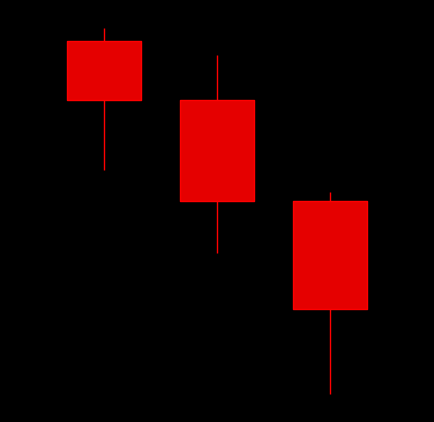

In [91]:
query = generate_query(generate_exclude_month_query_for_train(month_test_in_year), candle_type_and_directory_save)
df_spark_all = spark.sql(query)
df_pandas_all = df_spark_all.toPandas()



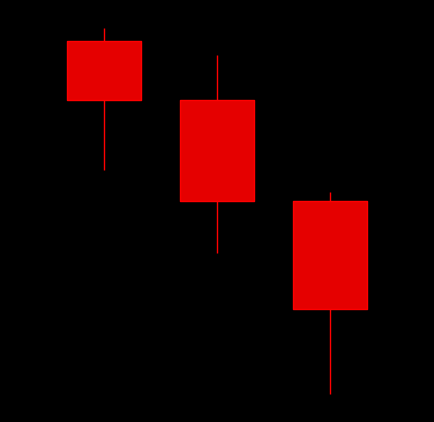

In [95]:
# df_to_draw = add_days_around_date(
#     "2024-09-14",
#     stock_df,
#     29,
#     2,
    
# )

df_to_draw = add_days_around_date(
    "2024-09-14",
    stock_df,
    0,
    2,
    
)

draw_candle_image(
    df_to_draw,
    None,
    figcolor="black",
    figscale=1,
    # show_macd=True,
    # show_macd_signal=True,
    # show_macd_histogram=True,
    # show_macd_histogram=True
)

In [41]:
# for train
is_run_for_train = input("Run for train? (y/n): ").lower()[0] == "y"
total_records_train = 0
if is_run_for_train:
    query = generate_query(generate_exclude_month_query_for_train(month_test_in_year), candle_type_and_directory_save)
    df_spark_all = spark.sql(query)
    df_pandas_all = df_spark_all.toPandas()
    
    for candle_type, directory_save in candle_type_and_directory_save.items():
        print(f"{candle_type=}")
        print(f"{directory_save=}")
        
        df_finded = df_pandas_all[df_pandas_all[candle_type]].sort_values(Date_normalized)
        df_finded[Total_records] = len(df_finded)
        print(tabulate(df_finded[0:2], headers='keys', tablefmt='pretty'))
        dataset = save_to_tensorflow_dataset_with_ema_9_macd_history_trend_type(
            df_date=df_finded,
            df_original=stock_df,
            previous_days=previous_days,
            next_days=next_days,
            days_result=days_result,
            number_images_preview=0,
            save_dataset_to_folder=f"{folder_save}/train/{directory_save}",
            figscale=figscale,
            indicator=indicator,
            function_generate=generate_one_image_of_input_with_ema_9_macd_history_trend_type
        )
        if dataset is None:
            dataset = []
        total_records_train += len(dataset)
print(f"Total records for train: {total_records_train}")


candle_type='Is_start_bullish_engulfing_candle'
directory_save='bullish_engulfing'
+------+---------------+-----------------+-------+------+------+------+----------------------+----------------------+-----------------------+--------------+--------------------+--------------------+----------------------+------+------+------+-------+----------+---------------------+----------------------+----------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------------------------+-----------------------+---------------------+--------------------------+---------------------------+--------------------+------------------+---------------------------+----------------+---------------+-----------------------+----------------------+----------------------+---------------------+---------------------------+-----------------------------------+---------------------

In [42]:
# For continue learning and test
is_run_for_continue_learning = input("Run for continue learning? (y/n): ").lower()[0] == "y"
total_records_continue_learning = 0
if is_run_for_continue_learning:
    last_date_of_continue_learning = str(stock_df[Date].max().date()).replace("-", "_")
    folder_save_continue_learning = f"{folder_save}/continue_learning/to_{last_date_of_continue_learning}"
    os.makedirs(folder_save_continue_learning, exist_ok=True)
    
    query = generate_query(generate_include_month_query_for_test(month_test_in_year), candle_type_and_directory_save)
    df_spark_all = spark.sql(query)
    df_pandas_all = df_spark_all.toPandas()
    
    for candle_type, directory_save in candle_type_and_directory_save.items():
        print(f"{candle_type=}")
        print(f"{directory_save=}")
        
        df_finded = df_pandas_all[df_pandas_all[candle_type]].sort_values(Date_normalized)
        df_finded[Total_records] = len(df_finded)
        print(tabulate(df_finded[0:2], headers='keys', tablefmt='pretty'))
        dataset = save_to_tensorflow_dataset_with_ema_9_macd_history_trend_type(
            df_date=df_finded,
            df_original=stock_df,
            previous_days=previous_days,
            next_days=next_days,
            days_result=days_result,
            number_images_preview=0,
            save_dataset_to_folder=f"{folder_save_continue_learning}/{directory_save}",
            figscale=figscale,
            indicator=indicator,
            function_generate=generate_one_image_of_input_with_ema_9_macd_history_trend_type
        )
        if dataset is None:
            dataset = []
        total_records_continue_learning += len(dataset)
print(f"Total records for continue learning: {total_records_continue_learning}")


Total records for continue learning: 0


In [43]:
# query = f"""
#     {base_query}
    
#     SELECT
#         COUNT(*) OVER() AS {Total_records},
#         *
#     FROM {data_stock_base}
#     ORDER BY {Date_normalized}
# """
# spark_df_all = spark.sql(query)
# pandas_df_all = spark_df_all.toPandas()
# pandas_df_all.to_excel("../dump_df/btc_all_data_6.xlsx")

In [44]:
month_test_in_year_copy = month_test_in_year
# for key, value in month_test_in_year.items():
#     month_test_in_year_copy[int(key)] = int(value)

In [45]:
config = {
    "month_test_in_year": month_test_in_year_copy,
    "candle_type_and_directory_save": candle_type_and_directory_save,
    "folder_save": folder_save,
    "figscale": figscale,
    "previous_days": previous_days,
    "next_days": next_days,
    "days_result": days_result,
    "file_csv": file_csv,
    
    "indicator": indicator,
    "total_records_train": total_records_train,
    "total_records_test": total_records_test,
}

In [46]:
config

{'month_test_in_year': {2012: [0],
  2013: [0],
  2014: [0],
  2015: [0],
  2016: [0],
  2017: [0],
  2018: [0],
  2019: [0],
  2020: [0],
  2021: [0],
  2022: [0],
  2023: [0],
  2024: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
 'candle_type_and_directory_save': {'Is_start_bullish_engulfing_candle': 'bullish_engulfing',
  'Is_start_bearish_engulfing_candle': 'bearish_engulfing',
  'Is_star_doji_candle': 'star_doji',
  'Is_dragonfly_doji_candle': 'dragonfly_doji',
  'Is_gravestone_doji_candle': 'gravestone_doji',
  'Is_start_morning_star_candle': 'morning_star',
  'Is_start_evening_star_candle': 'evening_star',
  'Is_hammer_candle': 'hammer',
  'Is_inverted_hammer_candle': 'inverted_hammer',
  'Is_start_harami_down_candle': 'harami_down',
  'Is_start_harami_up_candle': 'harami_up',
  'Is_start_tweezer_top_candle': 'tweezer_top',
  'Is_start_tweezer_bottom_candle': 'tweezer_bottom',
  'Is_marubozu_candle': 'marubozu',
  'Is_spin_candle': 'spin',
  'Is_start_next_3_day_up_candle': 'next_3

In [47]:
if is_run_for_continue_learning:
    with open(f"{folder_save_continue_learning}/config.json", "w") as f:
        config["last_date_of_continue_learning"] = last_date_of_continue_learning
        config["total_records_continue_learning"] = total_records_continue_learning
        json.dump(config, f, indent=4)

In [48]:
if is_run_for_test or is_run_for_train:
    with open(f"{folder_save}/config.json", "w") as f:
        json.dump(config, f, indent=4)